# NFL Play Prediction: Experiment 

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k
from tensorflow.keras.callbacks import Callback

## Load Data

Data via nflfastR. Variable selection, engineering & encoding are done in associated R script.

In [2]:
filepath = "data"
# filepath = "/content/drive/MyDrive/MSDS458_AI_and_DL/Assignment-4/data"

df_train_full = pd.read_csv(f'{filepath}/nfl_plays_train_update.csv')
df_valid_full = pd.read_csv(f'{filepath}/nfl_plays_valid_update.csv')
df_test_full = pd.read_csv(f'{filepath}/nfl_plays_test_update.csv')

## Helper Functions for Data Prep

removing pass location variables

In [3]:
def prepPlays(df, include_totals = False, include_wp = True, include_ep = True, include_epa_detail = False, fourth_down = False):
    # dropping columns that are not needed
    df = df.drop(['season', 'week', 'drive','series', 'surface', 'season_type', 'home_team','away_team', 'spread_line',
                   'game_date','play_id', 'desc','two_point_attempt', 'posteam_type','defteam', 'game_half', 'passer_name', 'passer_player_id',
                     'quarter_end', 'pass_attempt','rush_attempt','field_goal_attempt', 'punt_attempt', 'half_seconds_remaining', 'drive_play_count', 'pass_deep', 'pass_right', 'pass_left', 'yards_after_catch',
                  'pt_run_left_pct', 'pt_run_right_pct', 'pt_rush_wpa_play', 'pt_pass_wpa_play', 'dt_fd_pass_pct',
                  'dt_sd_pass_pct', 'dt_td_pass_pct', 'dt_gtg_pass_pct', 'dt_neutral_pass_pct', 'dt_scripted_pass_pct', 'dt_pass_pct',
       'dt_run_left_pct', 'dt_run_right_pct', 'dt_rush_wpa_play', 'dt_pass_wpa_play',
       'pt_sd_pass_pct', 'pt_td_pass_pct', 'pt_gtg_pass_pct', 'qb_dropback', 'qb_spike', 'qb_scramble', 'no_huddle', 'shotgun',
                  ], axis = 1)
    if include_totals == False:
        df = df.drop(['total_away_rush_epa', 'total_home_rush_epa', 'total_away_pass_epa', 'total_home_pass_epa', 'total_away_rush_wpa', 'total_home_rush_wpa', 'total_away_pass_wpa', 'total_home_pass_wpa'], axis=1)
    
    if include_wp == False:
        df = df.drop(['wp'], axis=1)

    if include_ep == False:
        df = df.drop(['ep'], axis=1)
    
    if include_epa_detail == False:
        df = df.drop(['air_epa', 'yac_epa'], axis=1)

    df['drive_time_of_possession'] = df['drive_time_of_possession'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
    df['roof'] = df['roof'].apply(lambda x: 'closed' if x == 'dome' else 'open' if x == 'outdoors' else x)
    df['roof'] = df['roof'].apply(lambda x: 1 if x == 'closed' else 0)
    
    # df['game_id_posteam'] = df['game_id'] + df['posteam']
    # df = df.drop(['game_id', 'posteam'], axis=1, inplace=True)

    # sorting the dataframe by game_id, posteam, and play number
    df = df.sort_values(by=['game_id', 'posteam', 'pt_play_no'])

    if fourth_down == True:
        df = df[df['down'] == 4]
        df = df[df['timeout']==0]
        df = df[df['pt_penalty'] == 0]
        df = df.drop(['down', 'yards_gained', 'epa', 'wpa', 'penalty_yards',
                      'pt_fd_pass_pct', 'pt_neutral_pass_pct', 'pt_scripted_pass_pct','pt_pass_pct',
                      'qb_hit', 'air_yards', 'first_down'
                      ], axis=1)
    else:
        df = df[df['down'] != 4]
        df = df[df['play_type'] != 'field_goal']
        df = df[df['play_type'] != 'punt']

    return df

def encodePlayType(df, play_types):
    n_play_types = len(play_types)
    df['play_type_encoded'] = df['play_type'].apply(lambda x: play_types.index(x))

    return df

## Helper Functions for Modeling/Post processing

In [4]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

class TimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()

    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        print(f"Training time: {self.train_end_time - self.train_start_time} seconds")

## Prep Non-4th down Plays Datasets

In [5]:
df_train = prepPlays(df_train_full[df_train_full['season'] >= 2020])
df_valid = prepPlays(df_valid_full[df_valid_full['season'] >= 2020])
df_test = prepPlays(df_test_full[df_test_full['season'] == 2022])

check for remaining categorical columns to encode

In [6]:
print("number of categorical columns: ", len(df_train.select_dtypes(include=['object']).columns))
print("number of numeric columns: ", len(df_train.select_dtypes(include=['int64','float64']).columns))
print("number of total columns: ", len(df_train.select_dtypes(include=['object']).columns) +  len(df_train.select_dtypes(include=['int64','float64']).columns))
print("categorical columns ",df_train.select_dtypes(include=['object']).columns.values)

number of categorical columns:  3
number of numeric columns:  46
number of total columns:  49
categorical columns  ['game_id' 'play_type' 'posteam']


good there, now print the remaining features

In [7]:
df_train.select_dtypes(include  =['int64', 'int32', 'float32', 'float64']).columns

Index(['total_line', 'drive_time_of_possession', 'yardline_100',
       'quarter_seconds_remaining', 'game_seconds_remaining', 'qtr',
       'drive_start', 'down', 'goal_to_go', 'ydstogo',
       'home_timeouts_remaining', 'away_timeouts_remaining',
       'score_differential', 'qb_epa', 'roof', 'temp', 'wind', 'penalty',
       'penalty_yards', 'timeout', 'qb_hit', 'air_yards', 'first_down',
       'yards_gained', 'epa', 'wpa', 'wp', 'ep', 'pt_play_no', 'pt_spread',
       'pt_fd_pass_pct', 'pt_neutral_pass_pct', 'pt_scripted_pass_pct',
       'pt_pass_pct', 'pt_rush_epa_play', 'pt_pass_epa_play',
       'dt_rush_epa_play', 'dt_pass_epa_play', 'pos_team_game_no',
       'def_team_game_no', 'qb_pass_attempts', 'qb_pass_epa_play_adj',
       'qb_pass_wpa_play_adj', 'pt_penalty', 'pt_timeout', 'pt_home'],
      dtype='object')

## Encode target variable

In [8]:
# df_train['run_direction'] = df_train['play_type'].map({'run_left':'left', 'run_right':'right', 'run_middle':'middle'})
df_train['play_type'] = df_train['play_type'].map({'run_left':'run', 'run_right':'run', 'run_middle':'run', 'pass':'pass', 'field_goal':'fg', 'punt':'punt'})

# df_valid['run_direction'] = df_valid['play_type'].map({'run_left':'left', 'run_right':'right', 'run_middle':'middle'})
df_valid['play_type'] = df_valid['play_type'].map({'run_left':'run', 'run_right':'run', 'run_middle':'run', 'pass':'pass', 'field_goal':'fg', 'punt':'punt'})

# df_test['run_direction'] = df_test['play_type'].map({'run_left':'left', 'run_right':'right', 'run_middle':'middle'})
df_test['play_type'] = df_test['play_type'].map({'run_left':'run', 'run_right':'run', 'run_middle':'run', 'pass':'pass', 'field_goal':'fg', 'punt':'punt'})

In [9]:
label_encoder = LabelEncoder()

df_train['play_type_encoded'] = label_encoder.fit_transform(df_train['play_type'])
df_valid['play_type_encoded'] = label_encoder.fit_transform(df_valid['play_type'])
df_test['play_type_encoded'] = label_encoder.fit_transform(df_test['play_type'])

Check class balance

In [10]:
print(df_train.groupby(['play_type_encoded', 'play_type']).size())
print(df_valid.groupby(['play_type_encoded', 'play_type']).size())
print(df_test.groupby(['play_type_encoded', 'play_type']).size())

play_type_encoded  play_type
0                  pass         29618
1                  run          18783
dtype: int64
play_type_encoded  play_type
0                  pass         10178
1                  run           6403
dtype: int64
play_type_encoded  play_type
0                  pass         19739
1                  run          13178
dtype: int64


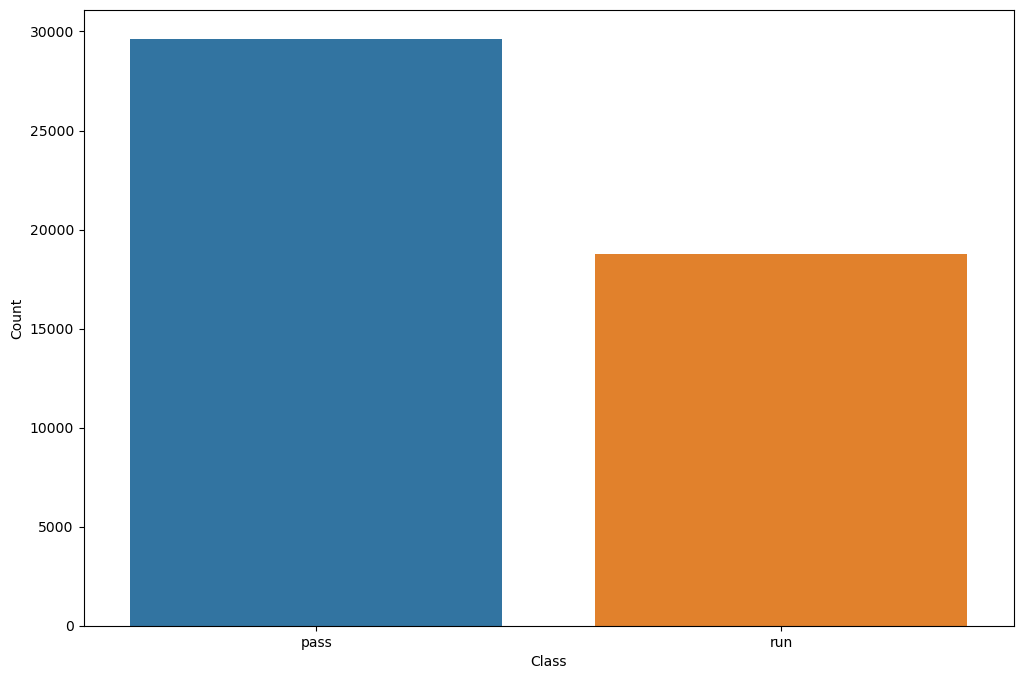

In [11]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(df_train['play_type']).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

## Scale Numeric Columns

In [12]:
scaler = MinMaxScaler()
numeric_cols = df_train.select_dtypes(include=['int64','float64']).columns
numeric_cols = numeric_cols[numeric_cols != 'pt_play_no']
numeric_cols = numeric_cols[numeric_cols != 'play_type_encoded']
numeric_cols = numeric_cols[numeric_cols != 'run_direction_encoded']

scaler.fit(df_train[numeric_cols])

df_train[numeric_cols] = scaler.transform(df_train[numeric_cols])
df_valid[numeric_cols] = scaler.transform(df_valid[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

reordering for display purposes

In [13]:
colorder = ['game_id', 'posteam', 'pt_play_no', 'play_type', 'play_type_encoded']
colorder = colorder + [col for col in df_train.columns if col not in colorder]
df_train = df_train[colorder]
df_valid = df_valid[colorder]
df_test = df_test[colorder]

## Slice and restructure data

Select columns and create lists grouped by posteam game. Structure is ***(posteam_games X plays_in_game X features)***

In [14]:
# convert to sequences of plays for each posteam/game
X_train = df_train.drop(['pt_play_no', 'play_type', 'play_type_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_train = df_train[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

X_valid = df_valid.drop(['pt_play_no', 'play_type', 'play_type_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_valid = df_valid[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

X_test = df_test.drop(['pt_play_no', 'play_type', 'play_type_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_test = df_test[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

In [15]:
# remove the identifier columns for each dataset
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        X_train[i][j] = X_train[i][j][2:]

for i in range(len(Y_train)):
    for j in range(len(Y_train[i])):
        Y_train[i][j] = Y_train[i][j][2:]

for i in range(len(X_valid)):
    for j in range(len(X_valid[i])):
        X_valid[i][j] = X_valid[i][j][2:]

for i in range(len(Y_valid)):
    for j in range(len(Y_valid[i])):
        Y_valid[i][j] = Y_valid[i][j][2:]

for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        X_test[i][j] = X_test[i][j][2:]

for i in range(len(Y_test)):
    for j in range(len(Y_test[i])):
        Y_test[i][j] = Y_test[i][j][2:]

In [16]:
def print_dimensions(nested_list):
    if isinstance(nested_list, list):
        print("number of games: ", len(nested_list))
        play_count = 0
        play_list = []
        for i in nested_list:
            plays = len(i)
            play_count += plays
            play_list.append(plays)
        print("average number of plays per game: ", np.mean(play_list))
        print("maximum number of plays per game:", np.max(play_list))
        print("total number of plays: ", play_count)
        print("number of features: ", len(nested_list[0][0]))
    else:
        print()
        
print("X dims")
print_dimensions(X_train)
print("")
print("Y dims")
print_dimensions(Y_train)

X dims
number of games:  786
average number of plays per game:  61.57888040712468
maximum number of plays per game: 90
total number of plays:  48401
number of features:  45

Y dims
number of games:  786
average number of plays per game:  61.57888040712468
maximum number of plays per game: 90
total number of plays:  48401
number of features:  1


In [17]:
# validation
print("X dims")
print_dimensions(X_valid)
print("")
print("Y dims")
print_dimensions(Y_valid)

X dims
number of games:  270
average number of plays per game:  61.41111111111111
maximum number of plays per game: 90
total number of plays:  16581
number of features:  45

Y dims
number of games:  270
average number of plays per game:  61.41111111111111
maximum number of plays per game: 90
total number of plays:  16581
number of features:  1


In [18]:
# validation
print("X dims")
print_dimensions(X_test)
print("")
print("Y dims")
print_dimensions(Y_test)

X dims
number of games:  542
average number of plays per game:  60.73247232472325
maximum number of plays per game: 91
total number of plays:  32917
number of features:  45

Y dims
number of games:  542
average number of plays per game:  60.73247232472325
maximum number of plays per game: 91
total number of plays:  32917
number of features:  1


## Create timeseries datasets

pad sequences

In [19]:
# pad sequences to max length
def padSequence(x_sequence, y_sequence, max_length = 105):
    X_padded = []
    Y_padded = []
    for i in range(len(x_sequence)):
        padded = np.pad(x_sequence[i], ((0, max_length-np.array(x_sequence[i]).shape[0]), (0,0)), 'constant')
        X_padded.append(padded)
    for i in range(len(y_sequence)):
        padded = np.pad(y_sequence[i], ((0, max_length-np.array(y_sequence[i]).shape[0]), (0,0)), 'constant')
        Y_padded.append(padded)
    return np.array(X_padded), np.array(Y_padded)


max_length = 91
X_train_padded, Y_train_padded = padSequence(X_train, Y_train, max_length)
X_valid_padded, Y_valid_padded = padSequence(X_valid, Y_valid, max_length)
X_test_padded, Y_test_padded = padSequence(X_test, Y_test, max_length)

Using the timeseries_dataset_from_array utility, but want to ensure that sequences are only created within the same game, and not overlapping games. Here, we loop through the games and create windowed sequences of a specified length for each game. For each game there will be one dataset object, which we then have to concatenate using the concatenate Dataset method.

In [20]:
sequence_length = 15
batch_size = 32
n_feats = len(X_train[0][0])
delay = sequence_length + 1 - 1
train_datasets = []
valid_datasets = []
test_datasets = []
for i in range(len(X_train)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_train_padded[i][:-delay],
        targets = np.ravel(Y_train_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    train_datasets.append(dataset)

train_dataset = train_datasets[0]
for i in range(1, len(train_datasets)):
    train_dataset = train_dataset.concatenate(train_datasets[i])

for i in range(len(X_valid_padded)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_valid_padded[i][:-delay],
        targets = np.ravel(Y_valid_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    valid_datasets.append(dataset)

valid_dataset = valid_datasets[0]
for i in range(1, len(valid_datasets)):
    valid_dataset = valid_dataset.concatenate(valid_datasets[i])

for i in range(len(X_test_padded)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_test_padded[i][:-delay],
        targets = np.ravel(Y_test_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    test_datasets.append(dataset)

test_dataset = test_datasets[0]
for i in range(1, len(test_datasets)):
    test_dataset = test_dataset.concatenate(test_datasets[i])

check the dimensions of the data within the train_dataset

In [21]:
# for element in train_dataset:
#     # print(element[0])
#     print("features")
#     print(element[0].shape)
#     # print(element[1])
#     print("targets")
#     print(element[1].shape)
#     break

## Build Models

### Dropback Model 01

class weights

In [22]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = np.unique(df_train['play_type_encoded'])
class_weights = compute_class_weight('balanced', classes = class_labels, y = df_train['play_type_encoded'])
class_weight_dict = dict(zip(class_labels, class_weights))

class_weight_dict

{0: 0.8170875818758863, 1: 1.2884257040941276}

In [23]:
keras.backend.clear_session()

inputs = keras.Input(shape=(sequence_length, n_feats))
x = keras.layers.Masking(mask_value=0.0)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(32, recurrent_dropout = .1, return_sequences = False))(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 45)]          0         
                                                                 
 masking (Masking)           (None, 15, 45)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               19968     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 20,098
Trainable params: 20,098
Non-trainable params: 0
_________________________________________________________

In [24]:
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("nflplay_db_01.h5", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience=5),
             TimeCallback()]
history = model.fit(train_dataset, class_weight = class_weight_dict, epochs = 25, validation_data = valid_dataset, callbacks = callbacks)

Epoch 1/25
1572/1572 [==============================] - 61s 37ms/step - loss: 0.5684 - accuracy: 0.6872 - val_loss: 0.5352 - val_accuracy: 0.6912
Epoch 2/25
1572/1572 [==============================] - 41s 26ms/step - loss: 0.5270 - accuracy: 0.7085 - val_loss: 0.5123 - val_accuracy: 0.7163
Epoch 3/25
1572/1572 [==============================] - 57s 36ms/step - loss: 0.5130 - accuracy: 0.7190 - val_loss: 0.4958 - val_accuracy: 0.7302
Epoch 4/25
1572/1572 [==============================] - 57s 36ms/step - loss: 0.5038 - accuracy: 0.7256 - val_loss: 0.4909 - val_accuracy: 0.7314
Epoch 5/25
1572/1572 [==============================] - 60s 38ms/step - loss: 0.4961 - accuracy: 0.7294 - val_loss: 0.4815 - val_accuracy: 0.7370
Epoch 6/25
1572/1572 [==============================] - 62s 40ms/step - loss: 0.4946 - accuracy: 0.7293 - val_loss: 0.4823 - val_accuracy: 0.7381
Epoch 7/25
1572/1572 [==============================] - 62s 39ms/step - loss: 0.4899 - accuracy: 0.7316 - val_loss: 0.4807 -

In [25]:
model = keras.models.load_model("nflplay_db_01.h5")
model.evaluate(test_dataset)

1084/1084 [==============================] - 128s 18ms/step - loss: 0.4683 - accuracy: 0.7405


[0.46829891204833984, 0.7405368685722351]

1084/1084 [==============================] - 18s 16ms/step


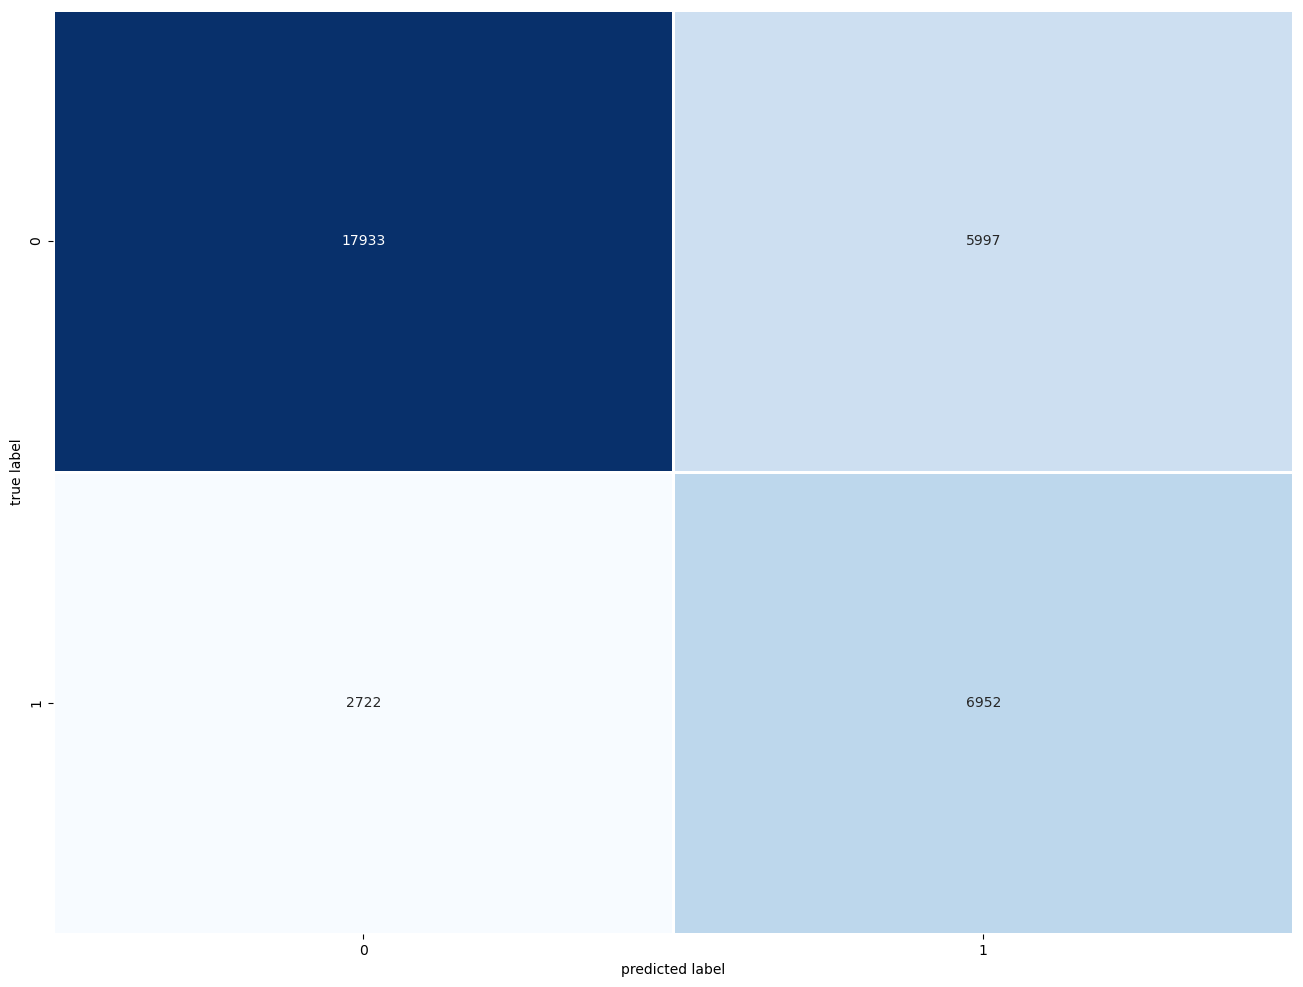

In [26]:
y_pred = model.predict(test_dataset)
y_class_pred = np.argmax(y_pred, axis=-1)
y_act = np.concatenate([y for _, y in test_dataset], axis=0)

plot_confusion_matrix(y_act, y_class_pred)

In [27]:
print_validation_report(y_act, y_class_pred)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.75      0.80     23930
           1       0.54      0.72      0.61      9674

    accuracy                           0.74     33604
   macro avg       0.70      0.73      0.71     33604
weighted avg       0.77      0.74      0.75     33604

Accuracy Score: 0.7405368408522794
Root Mean Square Error: 0.5093752635805163


### Dropback Model 2

In [28]:
keras.backend.clear_session()

inputs = keras.Input(shape=(sequence_length, n_feats))
x = keras.layers.Masking(mask_value=0.0)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(16, recurrent_dropout = .1, return_sequences = False))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 45)]          0         
                                                                 
 masking (Masking)           (None, 15, 45)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               7936      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                             

In [29]:
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("nflplay_db_02.h5", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience=5),
             TimeCallback()]
history = model.fit(train_dataset, class_weight = class_weight_dict, epochs = 25, validation_data = valid_dataset, callbacks = callbacks)

Epoch 1/25
1572/1572 [==============================] - 48s 28ms/step - loss: 0.5707 - accuracy: 0.6790 - val_loss: 0.5402 - val_accuracy: 0.6860
Epoch 2/25
1572/1572 [==============================] - 48s 31ms/step - loss: 0.5280 - accuracy: 0.7001 - val_loss: 0.5044 - val_accuracy: 0.7162
Epoch 3/25
1572/1572 [==============================] - 45s 29ms/step - loss: 0.5150 - accuracy: 0.7046 - val_loss: 0.5206 - val_accuracy: 0.7085
Epoch 4/25
1572/1572 [==============================] - 42s 27ms/step - loss: 0.5084 - accuracy: 0.7132 - val_loss: 0.4964 - val_accuracy: 0.7303
Epoch 5/25
1572/1572 [==============================] - 41s 26ms/step - loss: 0.5044 - accuracy: 0.7146 - val_loss: 0.4891 - val_accuracy: 0.7292
Epoch 6/25
1572/1572 [==============================] - 40s 26ms/step - loss: 0.4968 - accuracy: 0.7192 - val_loss: 0.4895 - val_accuracy: 0.7293
Epoch 7/25
1572/1572 [==============================] - 41s 26ms/step - loss: 0.4974 - accuracy: 0.7196 - val_loss: 0.4868 -

In [33]:
model = keras.models.load_model("nflplay_db_02.h5")
model.evaluate(test_dataset)

1084/1084 [==============================] - 11s 10ms/step - loss: 0.4829 - accuracy: 0.7244


[0.4828885495662689, 0.7243780493736267]

1084/1084 [==============================] - 11s 10ms/step


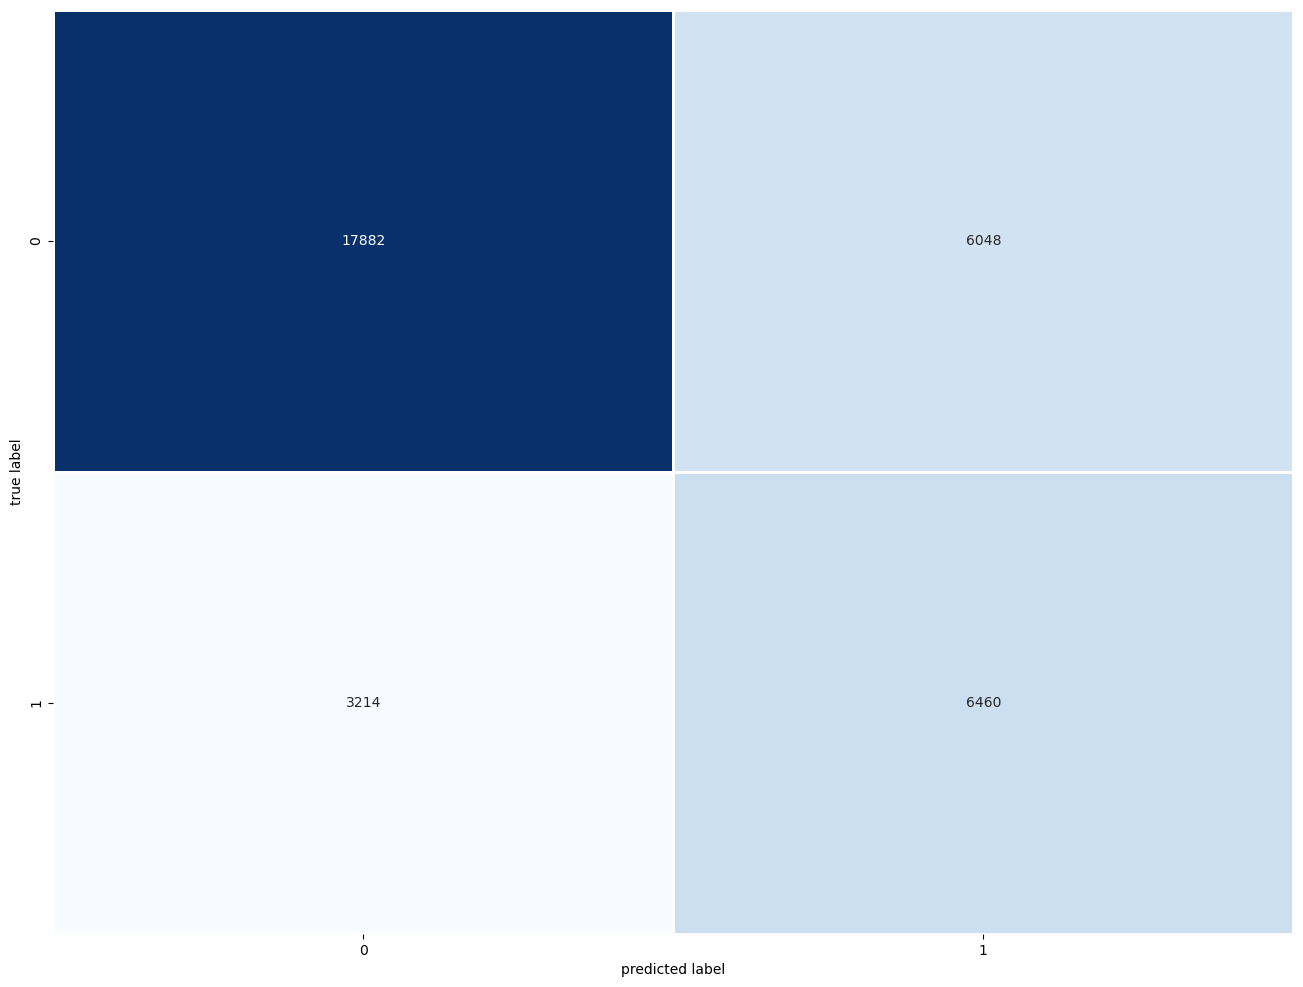

In [34]:
y_pred = model.predict(test_dataset)
y_class_pred = np.argmax(y_pred, axis=-1)
y_act = np.concatenate([y for _, y in test_dataset], axis=0)

plot_confusion_matrix(y_act, y_class_pred)

In [35]:
print_validation_report(y_act, y_class_pred)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.75      0.79     23930
           1       0.52      0.67      0.58      9674

    accuracy                           0.72     33604
   macro avg       0.68      0.71      0.69     33604
weighted avg       0.75      0.72      0.73     33604

Accuracy Score: 0.7243780502321152
Root Mean Square Error: 0.524997095008996
